In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"

data = Data()

data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../dataset/EthanT3/", postfix = "EthanT3", target=target)

data.include(data_path = "../../dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../dataset/EthenT3/", postfix = "EthenT3", target=target)

data.include(data_path = "../../dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

# SetUp descriptor And Normalisation

In [4]:
import pickle

model_path = "../../models/Descriptor"
target = "P"

descriptor_C = pickle.load(open(model_path + "C/" + target + "/descriptor.dump", "rb"))
descriptor_H = pickle.load(open(model_path + "H/" + target + "/descriptor.dump", "rb"))

descriptors = {
    "C": descriptor_C,
    "H": descriptor_H
}

In [5]:
descriptor_H

In [6]:
normalisations = {
    "C": np.load(model_path + "C/" + target + "/normalisation.npy"),
    "H": np.load(model_path + "H/" + target + "/normalisation.npy")
}

# Fetch Networks 

In [7]:
path = model_path

name_C = model_path + "C/" + target + "/C_" + target + ".h5"
name_H = model_path + "H/" + target + "/H_" + target + ".h5"


model_C = keras.models.load_model(name_C)
model_H = keras.models.load_model(name_H)

networks = {
    "C": model_C,
    "H": model_H
}

# Guess Method 

In [11]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu, AbstractDataset
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from pyscf.scf import hf
from SCFInitialGuess.utilities.dataset import density_from_fock, fock_from_density

def init_guess_by_ann(mol):
    
    mole = mol.get_pyscf_molecule()
    
    p  = hf.init_guess_by_wolfsberg_helmholtz(mole).copy() # TODO set up my own GWH in SCFInitialGuess
    
    for atom_index, atom in enumerate(mol.species):
        
        mask = mol.make_atom_mask(atom_index)
        
        
        G = descriptors[atom].calculate_atom_descriptor(
            atom_index, 
            mol,
            descriptors[atom].number_of_descriptors
        )
        
        G_norm = AbstractDataset.normalize(G, *normalisations[atom])
        
        #f(G)
        f = networks[atom].predict(G.reshape(1, -1))
        
        f_batch = reconstruct_from_triu(
            f,
            N_BASIS[mol.basis][atom]
        )
        
        p[mask] = f_batch.flatten()
        
    h = hf.get_hcore(mole)
    s = hf.get_ovlp(mole)
        
    # add iteration
    p = density_from_fock(fock_from_density(p, s, h, mole), s, mole)
        
    return p
        
    

# Analysis 

## Utils 

In [9]:
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    #train=(s_train, p_train),
    train=(data.S[0], data.T[0]),
    validation=(data.S[1], data.T[1]),
    test=(data.S[2], data.T[2]),
    mu=0,
    std=1
)

 ## Execution 

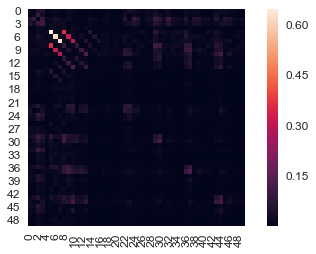

In [13]:
sns.heatmap(np.abs(init_guess_by_ann(data.molecules[2][0]) \
                   - hf.init_guess_by_wolfsberg_helmholtz(data.molecules[2][0].get_pyscf_molecule())), square=True)

In [14]:
p_nn = np.array([
    init_guess_by_ann(mol) for mol in data.molecules[2]
])

In [15]:
np.save("data/p_nn.npy", p_nn)

In [16]:
p_nn = np.load("data/p_nn.npy")

# Scatter 

In [ ]:
plt.rc("figure", figsize=(6,5))

In [ ]:
def flatten(x):
    y = []
    for xi in x:
        y += list(xi.flatten())
    return y

p_exp = flatten(data.T[2])
p_nn_flatten = flatten(p_nn)

In [ ]:
ind = np.arange(len(p_exp))
np.random.shuffle(ind)
print(len(p_exp), len(p_nn_flatten))

In [ ]:
n_max = len(p_exp)
plt.scatter(
    np.array(p_exp),#[ind[:n_max]], 
    np.array(p_nn_flatten),#[ind[:n_max]]
)

plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)

plt.xlabel("Corrseponding Element in Converged / 1")
plt.ylabel("Predicted by Guesses / 1")

plt.tight_layout()

plt.show()

# Properties 

In [17]:
from SCFInitialGuess.utilities.analysis import analyze_raw_batch, format_raw

from SCFInitialGuess.utilities.analysis import analyze_raw_batch
result = analyze_raw_batch(
    p_nn,
    data.T[2],
    data.S[2],
    data.molecules[2]
)

[ ] 2019-01-19 15:33:43: 1 / 2119
[ ] 2019-01-19 15:33:43: 2 / 2119
[ ] 2019-01-19 15:33:44: 3 / 2119
[ ] 2019-01-19 15:33:44: 4 / 2119
[ ] 2019-01-19 15:33:44: 5 / 2119
[ ] 2019-01-19 15:33:45: 6 / 2119
[ ] 2019-01-19 15:33:45: 7 / 2119
[ ] 2019-01-19 15:33:45: 8 / 2119
[ ] 2019-01-19 15:33:46: 9 / 2119
[ ] 2019-01-19 15:33:46: 10 / 2119
[ ] 2019-01-19 15:33:46: 11 / 2119
[ ] 2019-01-19 15:33:46: 12 / 2119
[ ] 2019-01-19 15:33:47: 13 / 2119
[ ] 2019-01-19 15:33:47: 14 / 2119
[ ] 2019-01-19 15:33:47: 15 / 2119
[ ] 2019-01-19 15:33:47: 16 / 2119
[ ] 2019-01-19 15:33:48: 17 / 2119
[ ] 2019-01-19 15:33:48: 18 / 2119
[ ] 2019-01-19 15:33:48: 19 / 2119
[ ] 2019-01-19 15:33:49: 20 / 2119
[ ] 2019-01-19 15:33:49: 21 / 2119
[ ] 2019-01-19 15:33:49: 22 / 2119
[ ] 2019-01-19 15:33:49: 23 / 2119
[ ] 2019-01-19 15:33:50: 24 / 2119
[ ] 2019-01-19 15:33:50: 25 / 2119
[ ] 2019-01-19 15:33:50: 26 / 2119
[ ] 2019-01-19 15:33:51: 27 / 2119
[ ] 2019-01-19 15:33:51: 28 / 2119
[ ] 2019-01-19 15:33:51: 29 /

[ ] 2019-01-19 15:34:54: 232 / 2119
[ ] 2019-01-19 15:34:54: 233 / 2119
[ ] 2019-01-19 15:34:55: 234 / 2119
[ ] 2019-01-19 15:34:55: 235 / 2119
[ ] 2019-01-19 15:34:55: 236 / 2119
[ ] 2019-01-19 15:34:55: 237 / 2119
[ ] 2019-01-19 15:34:55: 238 / 2119
[ ] 2019-01-19 15:34:56: 239 / 2119
[ ] 2019-01-19 15:34:56: 240 / 2119
[ ] 2019-01-19 15:34:56: 241 / 2119
[ ] 2019-01-19 15:34:56: 242 / 2119
[ ] 2019-01-19 15:34:57: 243 / 2119
[ ] 2019-01-19 15:34:57: 244 / 2119
[ ] 2019-01-19 15:34:57: 245 / 2119
[ ] 2019-01-19 15:34:57: 246 / 2119
[ ] 2019-01-19 15:34:57: 247 / 2119
[ ] 2019-01-19 15:34:58: 248 / 2119
[ ] 2019-01-19 15:34:58: 249 / 2119
[ ] 2019-01-19 15:34:58: 250 / 2119
[ ] 2019-01-19 15:34:59: 251 / 2119
[ ] 2019-01-19 15:34:59: 252 / 2119
[ ] 2019-01-19 15:34:59: 253 / 2119
[ ] 2019-01-19 15:34:59: 254 / 2119
[ ] 2019-01-19 15:35:00: 255 / 2119
[ ] 2019-01-19 15:35:00: 256 / 2119
[ ] 2019-01-19 15:35:00: 257 / 2119
[ ] 2019-01-19 15:35:00: 258 / 2119
[ ] 2019-01-19 15:35:01: 259

[ ] 2019-01-19 15:35:52: 460 / 2119
[ ] 2019-01-19 15:35:52: 461 / 2119
[ ] 2019-01-19 15:35:53: 462 / 2119
[ ] 2019-01-19 15:35:53: 463 / 2119
[ ] 2019-01-19 15:35:53: 464 / 2119
[ ] 2019-01-19 15:35:54: 465 / 2119
[ ] 2019-01-19 15:35:54: 466 / 2119
[ ] 2019-01-19 15:35:54: 467 / 2119
[ ] 2019-01-19 15:35:54: 468 / 2119
[ ] 2019-01-19 15:35:55: 469 / 2119
[ ] 2019-01-19 15:35:55: 470 / 2119
[ ] 2019-01-19 15:35:55: 471 / 2119
[ ] 2019-01-19 15:35:55: 472 / 2119
[ ] 2019-01-19 15:35:56: 473 / 2119
[ ] 2019-01-19 15:35:56: 474 / 2119
[ ] 2019-01-19 15:35:56: 475 / 2119
[ ] 2019-01-19 15:35:56: 476 / 2119
[ ] 2019-01-19 15:35:57: 477 / 2119
[ ] 2019-01-19 15:35:57: 478 / 2119
[ ] 2019-01-19 15:35:57: 479 / 2119
[ ] 2019-01-19 15:35:57: 480 / 2119
[ ] 2019-01-19 15:35:58: 481 / 2119
[ ] 2019-01-19 15:35:58: 482 / 2119
[ ] 2019-01-19 15:35:58: 483 / 2119
[ ] 2019-01-19 15:35:58: 484 / 2119
[ ] 2019-01-19 15:35:59: 485 / 2119
[ ] 2019-01-19 15:35:59: 486 / 2119
[ ] 2019-01-19 15:35:59: 487

[ ] 2019-01-19 15:38:15: 688 / 2119
[ ] 2019-01-19 15:38:16: 689 / 2119
[ ] 2019-01-19 15:38:17: 690 / 2119
[ ] 2019-01-19 15:38:18: 691 / 2119
[ ] 2019-01-19 15:38:18: 692 / 2119
[ ] 2019-01-19 15:38:19: 693 / 2119
[ ] 2019-01-19 15:38:20: 694 / 2119
[ ] 2019-01-19 15:38:21: 695 / 2119
[ ] 2019-01-19 15:38:21: 696 / 2119
[ ] 2019-01-19 15:38:22: 697 / 2119
[ ] 2019-01-19 15:38:23: 698 / 2119
[ ] 2019-01-19 15:38:23: 699 / 2119
[ ] 2019-01-19 15:38:24: 700 / 2119
[ ] 2019-01-19 15:38:25: 701 / 2119
[ ] 2019-01-19 15:38:26: 702 / 2119
[ ] 2019-01-19 15:38:26: 703 / 2119
[ ] 2019-01-19 15:38:27: 704 / 2119
[ ] 2019-01-19 15:38:28: 705 / 2119
[ ] 2019-01-19 15:38:29: 706 / 2119
[ ] 2019-01-19 15:38:29: 707 / 2119
[ ] 2019-01-19 15:38:30: 708 / 2119
[ ] 2019-01-19 15:38:31: 709 / 2119
[ ] 2019-01-19 15:38:31: 710 / 2119
[ ] 2019-01-19 15:38:32: 711 / 2119
[ ] 2019-01-19 15:38:32: 712 / 2119
[ ] 2019-01-19 15:38:32: 713 / 2119
[ ] 2019-01-19 15:38:33: 714 / 2119
[ ] 2019-01-19 15:38:33: 715

[ ] 2019-01-19 15:39:50: 916 / 2119
[ ] 2019-01-19 15:39:50: 917 / 2119
[ ] 2019-01-19 15:39:51: 918 / 2119
[ ] 2019-01-19 15:39:51: 919 / 2119
[ ] 2019-01-19 15:39:52: 920 / 2119
[ ] 2019-01-19 15:39:52: 921 / 2119
[ ] 2019-01-19 15:39:53: 922 / 2119
[ ] 2019-01-19 15:39:53: 923 / 2119
[ ] 2019-01-19 15:39:54: 924 / 2119
[ ] 2019-01-19 15:39:54: 925 / 2119
[ ] 2019-01-19 15:39:55: 926 / 2119
[ ] 2019-01-19 15:39:55: 927 / 2119
[ ] 2019-01-19 15:39:56: 928 / 2119
[ ] 2019-01-19 15:39:56: 929 / 2119
[ ] 2019-01-19 15:39:57: 930 / 2119
[ ] 2019-01-19 15:39:57: 931 / 2119
[ ] 2019-01-19 15:39:58: 932 / 2119
[ ] 2019-01-19 15:39:58: 933 / 2119
[ ] 2019-01-19 15:39:58: 934 / 2119
[ ] 2019-01-19 15:39:59: 935 / 2119
[ ] 2019-01-19 15:39:59: 936 / 2119
[ ] 2019-01-19 15:40:00: 937 / 2119
[ ] 2019-01-19 15:40:00: 938 / 2119
[ ] 2019-01-19 15:40:00: 939 / 2119
[ ] 2019-01-19 15:40:01: 940 / 2119
[ ] 2019-01-19 15:40:01: 941 / 2119
[ ] 2019-01-19 15:40:01: 942 / 2119
[ ] 2019-01-19 15:40:02: 943

[ ] 2019-01-19 15:41:28: 1140 / 2119
[ ] 2019-01-19 15:41:28: 1141 / 2119
[ ] 2019-01-19 15:41:29: 1142 / 2119
[ ] 2019-01-19 15:41:29: 1143 / 2119
[ ] 2019-01-19 15:41:29: 1144 / 2119
[ ] 2019-01-19 15:41:30: 1145 / 2119
[ ] 2019-01-19 15:41:30: 1146 / 2119
[ ] 2019-01-19 15:41:31: 1147 / 2119
[ ] 2019-01-19 15:41:31: 1148 / 2119
[ ] 2019-01-19 15:41:32: 1149 / 2119
[ ] 2019-01-19 15:41:32: 1150 / 2119
[ ] 2019-01-19 15:41:33: 1151 / 2119
[ ] 2019-01-19 15:41:33: 1152 / 2119
[ ] 2019-01-19 15:41:33: 1153 / 2119
[ ] 2019-01-19 15:41:34: 1154 / 2119
[ ] 2019-01-19 15:41:34: 1155 / 2119
[ ] 2019-01-19 15:41:35: 1156 / 2119
[ ] 2019-01-19 15:41:35: 1157 / 2119
[ ] 2019-01-19 15:41:36: 1158 / 2119
[ ] 2019-01-19 15:41:36: 1159 / 2119
[ ] 2019-01-19 15:41:37: 1160 / 2119
[ ] 2019-01-19 15:41:37: 1161 / 2119
[ ] 2019-01-19 15:41:38: 1162 / 2119
[ ] 2019-01-19 15:41:38: 1163 / 2119
[ ] 2019-01-19 15:41:39: 1164 / 2119
[ ] 2019-01-19 15:41:39: 1165 / 2119
[ ] 2019-01-19 15:41:39: 1166 / 2119
[

[ ] 2019-01-19 15:42:48: 1362 / 2119
[ ] 2019-01-19 15:42:48: 1363 / 2119
[ ] 2019-01-19 15:42:49: 1364 / 2119
[ ] 2019-01-19 15:42:49: 1365 / 2119
[ ] 2019-01-19 15:42:49: 1366 / 2119
[ ] 2019-01-19 15:42:50: 1367 / 2119
[ ] 2019-01-19 15:42:50: 1368 / 2119
[ ] 2019-01-19 15:42:50: 1369 / 2119
[ ] 2019-01-19 15:42:51: 1370 / 2119
[ ] 2019-01-19 15:42:51: 1371 / 2119
[ ] 2019-01-19 15:42:51: 1372 / 2119
[ ] 2019-01-19 15:42:52: 1373 / 2119
[ ] 2019-01-19 15:42:52: 1374 / 2119
[ ] 2019-01-19 15:42:52: 1375 / 2119
[ ] 2019-01-19 15:42:53: 1376 / 2119
[ ] 2019-01-19 15:42:53: 1377 / 2119
[ ] 2019-01-19 15:42:53: 1378 / 2119
[ ] 2019-01-19 15:42:54: 1379 / 2119
[ ] 2019-01-19 15:42:54: 1380 / 2119
[ ] 2019-01-19 15:42:54: 1381 / 2119
[ ] 2019-01-19 15:42:54: 1382 / 2119
[ ] 2019-01-19 15:42:55: 1383 / 2119
[ ] 2019-01-19 15:42:55: 1384 / 2119
[ ] 2019-01-19 15:42:56: 1385 / 2119
[ ] 2019-01-19 15:42:56: 1386 / 2119
[ ] 2019-01-19 15:42:56: 1387 / 2119
[ ] 2019-01-19 15:42:57: 1388 / 2119
[

[ ] 2019-01-19 15:44:01: 1584 / 2119
[ ] 2019-01-19 15:44:02: 1585 / 2119
[ ] 2019-01-19 15:44:02: 1586 / 2119
[ ] 2019-01-19 15:44:02: 1587 / 2119
[ ] 2019-01-19 15:44:03: 1588 / 2119
[ ] 2019-01-19 15:44:03: 1589 / 2119
[ ] 2019-01-19 15:44:03: 1590 / 2119
[ ] 2019-01-19 15:44:04: 1591 / 2119
[ ] 2019-01-19 15:44:04: 1592 / 2119
[ ] 2019-01-19 15:44:04: 1593 / 2119
[ ] 2019-01-19 15:44:04: 1594 / 2119
[ ] 2019-01-19 15:44:05: 1595 / 2119
[ ] 2019-01-19 15:44:05: 1596 / 2119
[ ] 2019-01-19 15:44:05: 1597 / 2119
[ ] 2019-01-19 15:44:06: 1598 / 2119
[ ] 2019-01-19 15:44:06: 1599 / 2119
[ ] 2019-01-19 15:44:06: 1600 / 2119
[ ] 2019-01-19 15:44:07: 1601 / 2119
[ ] 2019-01-19 15:44:07: 1602 / 2119
[ ] 2019-01-19 15:44:07: 1603 / 2119
[ ] 2019-01-19 15:44:08: 1604 / 2119
[ ] 2019-01-19 15:44:08: 1605 / 2119
[ ] 2019-01-19 15:44:08: 1606 / 2119
[ ] 2019-01-19 15:44:09: 1607 / 2119
[ ] 2019-01-19 15:44:09: 1608 / 2119
[ ] 2019-01-19 15:44:09: 1609 / 2119
[ ] 2019-01-19 15:44:10: 1610 / 2119
[

[ ] 2019-01-19 15:45:11: 1806 / 2119
[ ] 2019-01-19 15:45:12: 1807 / 2119
[ ] 2019-01-19 15:45:12: 1808 / 2119
[ ] 2019-01-19 15:45:12: 1809 / 2119
[ ] 2019-01-19 15:45:12: 1810 / 2119
[ ] 2019-01-19 15:45:13: 1811 / 2119
[ ] 2019-01-19 15:45:13: 1812 / 2119
[ ] 2019-01-19 15:45:13: 1813 / 2119
[ ] 2019-01-19 15:45:14: 1814 / 2119
[ ] 2019-01-19 15:45:14: 1815 / 2119
[ ] 2019-01-19 15:45:14: 1816 / 2119
[ ] 2019-01-19 15:45:14: 1817 / 2119
[ ] 2019-01-19 15:45:15: 1818 / 2119
[ ] 2019-01-19 15:45:15: 1819 / 2119
[ ] 2019-01-19 15:45:15: 1820 / 2119
[ ] 2019-01-19 15:45:16: 1821 / 2119
[ ] 2019-01-19 15:45:16: 1822 / 2119
[ ] 2019-01-19 15:45:16: 1823 / 2119
[ ] 2019-01-19 15:45:17: 1824 / 2119
[ ] 2019-01-19 15:45:17: 1825 / 2119
[ ] 2019-01-19 15:45:17: 1826 / 2119
[ ] 2019-01-19 15:45:18: 1827 / 2119
[ ] 2019-01-19 15:45:18: 1828 / 2119
[ ] 2019-01-19 15:45:18: 1829 / 2119
[ ] 2019-01-19 15:45:19: 1830 / 2119
[ ] 2019-01-19 15:45:19: 1831 / 2119
[ ] 2019-01-19 15:45:19: 1832 / 2119
[

[ ] 2019-01-19 15:46:20: 2028 / 2119
[ ] 2019-01-19 15:46:20: 2029 / 2119
[ ] 2019-01-19 15:46:21: 2030 / 2119
[ ] 2019-01-19 15:46:21: 2031 / 2119
[ ] 2019-01-19 15:46:21: 2032 / 2119
[ ] 2019-01-19 15:46:22: 2033 / 2119
[ ] 2019-01-19 15:46:22: 2034 / 2119
[ ] 2019-01-19 15:46:22: 2035 / 2119
[ ] 2019-01-19 15:46:22: 2036 / 2119
[ ] 2019-01-19 15:46:23: 2037 / 2119
[ ] 2019-01-19 15:46:23: 2038 / 2119
[ ] 2019-01-19 15:46:23: 2039 / 2119
[ ] 2019-01-19 15:46:24: 2040 / 2119
[ ] 2019-01-19 15:46:24: 2041 / 2119
[ ] 2019-01-19 15:46:24: 2042 / 2119
[ ] 2019-01-19 15:46:25: 2043 / 2119
[ ] 2019-01-19 15:46:25: 2044 / 2119
[ ] 2019-01-19 15:46:25: 2045 / 2119
[ ] 2019-01-19 15:46:26: 2046 / 2119
[ ] 2019-01-19 15:46:26: 2047 / 2119
[ ] 2019-01-19 15:46:26: 2048 / 2119
[ ] 2019-01-19 15:46:27: 2049 / 2119
[ ] 2019-01-19 15:46:27: 2050 / 2119
[ ] 2019-01-19 15:46:27: 2051 / 2119
[ ] 2019-01-19 15:46:27: 2052 / 2119
[ ] 2019-01-19 15:46:28: 2053 / 2119
[ ] 2019-01-19 15:46:28: 2054 / 2119
[

In [18]:
print(format_raw(result))

AbsError: 6.26252E-03 +- 2.50636E-03
EhfError: 4.50744E-01 +- 5.57680E-01
IdemEror: 2.76460E-17 +- 8.78850E-18
OccError: 4.68861E-15 +- 3.81867E-15



## Pure 

In [19]:
from SCFInitialGuess.utilities.analysis import mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg
msg.print_level = 3

    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle


[ ] 2019-01-19 15:46:48: Iteration calculation: 0
[ ] 2019-01-19 15:46:48: Iteration calculation: 1
[ ] 2019-01-19 15:46:49: Iteration calculation: 2
[ ] 2019-01-19 15:46:49: Iteration calculation: 3
[ ] 2019-01-19 15:46:49: Iteration calculation: 4
[ ] 2019-01-19 15:46:50: Iteration calculation: 5
[ ] 2019-01-19 15:46:50: Iteration calculation: 6
[ ] 2019-01-19 15:46:50: Iteration calculation: 7
[ ] 2019-01-19 15:46:50: Iteration calculation: 8
[ ] 2019-01-19 15:46:51: Iteration calculation: 9
[ ] 2019-01-19 15:46:51: Iteration calculation: 10
[ ] 2019-01-19 15:46:51: Iteration calculation: 11
[ ] 2019-01-19 15:46:52: Iteration calculation: 12
[ ] 2019-01-19 15:46:52: Iteration calculation: 13
[ ] 2019-01-19 15:46:52: Iteration calculation: 14
[ ] 2019-01-19 15:46:53: Iteration calculation: 15
[ ] 2019-01-19 15:46:53: Iteration calculation: 16
[ ] 2019-01-19 15:46:53: Iteration calculation: 17
[ ] 2019-01-19 15:46:53: Iteration calculation: 18
[ ] 2019-01-19 15:46:54: Iteration calcul

[ ] 2019-01-19 15:47:37: Iteration calculation: 160
[ ] 2019-01-19 15:47:37: Iteration calculation: 161
[ ] 2019-01-19 15:47:37: Iteration calculation: 162
[ ] 2019-01-19 15:47:37: Iteration calculation: 163
[ ] 2019-01-19 15:47:38: Iteration calculation: 164
[ ] 2019-01-19 15:47:38: Iteration calculation: 165
[ ] 2019-01-19 15:47:38: Iteration calculation: 166
[ ] 2019-01-19 15:47:38: Iteration calculation: 167
[ ] 2019-01-19 15:47:39: Iteration calculation: 168
[ ] 2019-01-19 15:47:39: Iteration calculation: 169
[ ] 2019-01-19 15:47:39: Iteration calculation: 170
[ ] 2019-01-19 15:47:40: Iteration calculation: 171
[ ] 2019-01-19 15:47:40: Iteration calculation: 172
[ ] 2019-01-19 15:47:40: Iteration calculation: 173
[ ] 2019-01-19 15:47:41: Iteration calculation: 174
[ ] 2019-01-19 15:47:41: Iteration calculation: 175
[ ] 2019-01-19 15:47:41: Iteration calculation: 176
[ ] 2019-01-19 15:47:41: Iteration calculation: 177
[ ] 2019-01-19 15:47:42: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-19 15:48:51: Iteration calculation: 318
[ ] 2019-01-19 15:48:52: Iteration calculation: 319
[ ] 2019-01-19 15:48:52: Iteration calculation: 320
[ ] 2019-01-19 15:48:52: Iteration calculation: 321
[ ] 2019-01-19 15:48:52: Iteration calculation: 322
[ ] 2019-01-19 15:48:53: Iteration calculation: 323
[ ] 2019-01-19 15:48:53: Iteration calculation: 324
[ ] 2019-01-19 15:48:53: Iteration calculation: 325
[ ] 2019-01-19 15:48:53: Iteration calculation: 326
[ ] 2019-01-19 15:48:53: Iteration calculation: 327
[ ] 2019-01-19 15:48:54: Iteration calculation: 328
[ ] 2019-01-19 15:48:54: Iteration calculation: 329
[ ] 2019-01-19 15:48:54: Iteration calculation: 330
[ ] 2019-01-19 15:48:54: Iteration calculation: 331
[ ] 2019-01-19 15:48:55: Iteration calculation: 332
[ ] 2019-01-19 15:48:55: Iteration calculation: 333
[ ] 2019-01-19 15:48:55: Iteration calculation: 334
[ ] 2019-01-19 15:48:55: Iteration calculation: 335
[ ] 2019-01-19 15:48:56: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-19 15:49:33: Iteration calculation: 477
[ ] 2019-01-19 15:49:33: Iteration calculation: 478
[ ] 2019-01-19 15:49:33: Iteration calculation: 479
[ ] 2019-01-19 15:49:33: Iteration calculation: 480
[ ] 2019-01-19 15:49:33: Iteration calculation: 481
[ ] 2019-01-19 15:49:34: Iteration calculation: 482
[ ] 2019-01-19 15:49:34: Iteration calculation: 483
[ ] 2019-01-19 15:49:34: Iteration calculation: 484
[ ] 2019-01-19 15:49:34: Iteration calculation: 485
[ ] 2019-01-19 15:49:35: Iteration calculation: 486
[ ] 2019-01-19 15:49:35: Iteration calculation: 487
[ ] 2019-01-19 15:49:35: Iteration calculation: 488
[ ] 2019-01-19 15:49:35: Iteration calculation: 489
[ ] 2019-01-19 15:49:36: Iteration calculation: 490
[ ] 2019-01-19 15:49:36: Iteration calculation: 491
[ ] 2019-01-19 15:49:36: Iteration calculation: 492
[ ] 2019-01-19 15:49:36: Iteration calculation: 493
[ ] 2019-01-19 15:49:37: Iteration calculation: 494
[ ] 2019-01-19 15:49:37: Iteration calculation: 495
[ ] 2019-01-

[ ] 2019-01-19 15:51:35: Iteration calculation: 635
[ ] 2019-01-19 15:51:36: Iteration calculation: 636
[ ] 2019-01-19 15:51:37: Iteration calculation: 637
[ ] 2019-01-19 15:51:38: Iteration calculation: 638
[ ] 2019-01-19 15:51:39: Iteration calculation: 639
[ ] 2019-01-19 15:51:40: Iteration calculation: 640
[ ] 2019-01-19 15:51:42: Iteration calculation: 641
[ ] 2019-01-19 15:51:43: Iteration calculation: 642
[ ] 2019-01-19 15:51:45: Iteration calculation: 643
[ ] 2019-01-19 15:51:46: Iteration calculation: 644
[ ] 2019-01-19 15:51:47: Iteration calculation: 645
[ ] 2019-01-19 15:51:48: Iteration calculation: 646
[ ] 2019-01-19 15:51:49: Iteration calculation: 647
[ ] 2019-01-19 15:51:50: Iteration calculation: 648
[ ] 2019-01-19 15:51:51: Iteration calculation: 649
[ ] 2019-01-19 15:51:52: Iteration calculation: 650
[ ] 2019-01-19 15:51:53: Iteration calculation: 651
[ ] 2019-01-19 15:51:54: Iteration calculation: 652
[ ] 2019-01-19 15:51:55: Iteration calculation: 653
[ ] 2019-01-

[ ] 2019-01-19 15:54:18: Iteration calculation: 793
[ ] 2019-01-19 15:54:19: Iteration calculation: 794
[ ] 2019-01-19 15:54:20: Iteration calculation: 795
[ ] 2019-01-19 15:54:20: Iteration calculation: 796
[ ] 2019-01-19 15:54:21: Iteration calculation: 797
[ ] 2019-01-19 15:54:22: Iteration calculation: 798
[ ] 2019-01-19 15:54:23: Iteration calculation: 799
[ ] 2019-01-19 15:54:24: Iteration calculation: 800
[ ] 2019-01-19 15:54:24: Iteration calculation: 801
[ ] 2019-01-19 15:54:25: Iteration calculation: 802
[ ] 2019-01-19 15:54:26: Iteration calculation: 803
[ ] 2019-01-19 15:54:27: Iteration calculation: 804
[ ] 2019-01-19 15:54:28: Iteration calculation: 805
[ ] 2019-01-19 15:54:28: Iteration calculation: 806
[ ] 2019-01-19 15:54:29: Iteration calculation: 807
[ ] 2019-01-19 15:54:30: Iteration calculation: 808
[ ] 2019-01-19 15:54:31: Iteration calculation: 809
[ ] 2019-01-19 15:54:32: Iteration calculation: 810
[ ] 2019-01-19 15:54:33: Iteration calculation: 811
[ ] 2019-01-

[ ] 2019-01-19 15:57:33: Iteration calculation: 951
[ ] 2019-01-19 15:57:35: Iteration calculation: 952
[ ] 2019-01-19 15:57:37: Iteration calculation: 953
[ ] 2019-01-19 15:57:40: Iteration calculation: 954
[ ] 2019-01-19 15:57:42: Iteration calculation: 955
[ ] 2019-01-19 15:57:44: Iteration calculation: 956
[ ] 2019-01-19 15:57:47: Iteration calculation: 957
[ ] 2019-01-19 15:57:49: Iteration calculation: 958
[ ] 2019-01-19 15:57:51: Iteration calculation: 959
[ ] 2019-01-19 15:57:54: Iteration calculation: 960
[ ] 2019-01-19 15:57:56: Iteration calculation: 961
[ ] 2019-01-19 15:57:59: Iteration calculation: 962
[ ] 2019-01-19 15:58:01: Iteration calculation: 963
[ ] 2019-01-19 15:58:03: Iteration calculation: 964
[ ] 2019-01-19 15:58:06: Iteration calculation: 965
[ ] 2019-01-19 15:58:07: Iteration calculation: 966
[ ] 2019-01-19 15:58:09: Iteration calculation: 967
[ ] 2019-01-19 15:58:11: Iteration calculation: 968
[ ] 2019-01-19 15:58:12: Iteration calculation: 969
[ ] 2019-01-

[ ] 2019-01-19 16:00:54: Iteration calculation: 1107
[ ] 2019-01-19 16:00:55: Iteration calculation: 1108
[ ] 2019-01-19 16:00:56: Iteration calculation: 1109
[ ] 2019-01-19 16:00:57: Iteration calculation: 1110
[ ] 2019-01-19 16:00:58: Iteration calculation: 1111
[ ] 2019-01-19 16:00:59: Iteration calculation: 1112
[ ] 2019-01-19 16:01:00: Iteration calculation: 1113
[ ] 2019-01-19 16:01:01: Iteration calculation: 1114
[ ] 2019-01-19 16:01:02: Iteration calculation: 1115
[ ] 2019-01-19 16:01:04: Iteration calculation: 1116
[ ] 2019-01-19 16:01:04: Iteration calculation: 1117
[ ] 2019-01-19 16:01:05: Iteration calculation: 1118
[ ] 2019-01-19 16:01:06: Iteration calculation: 1119
[ ] 2019-01-19 16:01:07: Iteration calculation: 1120
[ ] 2019-01-19 16:01:07: Iteration calculation: 1121
[ ] 2019-01-19 16:01:08: Iteration calculation: 1122
[ ] 2019-01-19 16:01:09: Iteration calculation: 1123
[ ] 2019-01-19 16:01:10: Iteration calculation: 1124
[ ] 2019-01-19 16:01:10: Iteration calculation

[ ] 2019-01-19 16:03:44: Iteration calculation: 1262
[ ] 2019-01-19 16:03:44: Iteration calculation: 1263
[ ] 2019-01-19 16:03:45: Iteration calculation: 1264
[ ] 2019-01-19 16:03:47: Iteration calculation: 1265
[ ] 2019-01-19 16:03:48: Iteration calculation: 1266
[ ] 2019-01-19 16:03:50: Iteration calculation: 1267
[ ] 2019-01-19 16:03:51: Iteration calculation: 1268
[ ] 2019-01-19 16:03:52: Iteration calculation: 1269
[ ] 2019-01-19 16:03:53: Iteration calculation: 1270
[ ] 2019-01-19 16:03:55: Iteration calculation: 1271
[ ] 2019-01-19 16:03:56: Iteration calculation: 1272
[ ] 2019-01-19 16:03:58: Iteration calculation: 1273
[ ] 2019-01-19 16:04:00: Iteration calculation: 1274
[ ] 2019-01-19 16:04:01: Iteration calculation: 1275
[ ] 2019-01-19 16:04:02: Iteration calculation: 1276
[ ] 2019-01-19 16:04:04: Iteration calculation: 1277
[ ] 2019-01-19 16:04:06: Iteration calculation: 1278
[ ] 2019-01-19 16:04:08: Iteration calculation: 1279
[ ] 2019-01-19 16:04:09: Iteration calculation

[ ] 2019-01-19 16:07:03: Iteration calculation: 1417
[ ] 2019-01-19 16:07:05: Iteration calculation: 1418
[ ] 2019-01-19 16:07:07: Iteration calculation: 1419
[ ] 2019-01-19 16:07:10: Iteration calculation: 1420
[ ] 2019-01-19 16:07:12: Iteration calculation: 1421
[ ] 2019-01-19 16:07:14: Iteration calculation: 1422
[ ] 2019-01-19 16:07:17: Iteration calculation: 1423
[ ] 2019-01-19 16:07:19: Iteration calculation: 1424
[ ] 2019-01-19 16:07:21: Iteration calculation: 1425
[ ] 2019-01-19 16:07:22: Iteration calculation: 1426
[ ] 2019-01-19 16:07:24: Iteration calculation: 1427
[ ] 2019-01-19 16:07:25: Iteration calculation: 1428
[ ] 2019-01-19 16:07:27: Iteration calculation: 1429
[ ] 2019-01-19 16:07:28: Iteration calculation: 1430
[ ] 2019-01-19 16:07:29: Iteration calculation: 1431
[ ] 2019-01-19 16:07:30: Iteration calculation: 1432
[ ] 2019-01-19 16:07:31: Iteration calculation: 1433
[ ] 2019-01-19 16:07:32: Iteration calculation: 1434
[ ] 2019-01-19 16:07:33: Iteration calculation

[ ] 2019-01-19 16:10:50: Iteration calculation: 1572
[ ] 2019-01-19 16:10:51: Iteration calculation: 1573
[ ] 2019-01-19 16:10:52: Iteration calculation: 1574
[ ] 2019-01-19 16:10:52: Iteration calculation: 1575
[ ] 2019-01-19 16:10:53: Iteration calculation: 1576
[ ] 2019-01-19 16:10:54: Iteration calculation: 1577
[ ] 2019-01-19 16:10:55: Iteration calculation: 1578
[ ] 2019-01-19 16:10:56: Iteration calculation: 1579
[ ] 2019-01-19 16:10:56: Iteration calculation: 1580
[ ] 2019-01-19 16:10:57: Iteration calculation: 1581
[ ] 2019-01-19 16:10:58: Iteration calculation: 1582
[ ] 2019-01-19 16:10:58: Iteration calculation: 1583
[ ] 2019-01-19 16:10:59: Iteration calculation: 1584
[ ] 2019-01-19 16:11:00: Iteration calculation: 1585
[ ] 2019-01-19 16:11:00: Iteration calculation: 1586
[ ] 2019-01-19 16:11:01: Iteration calculation: 1587
[ ] 2019-01-19 16:11:01: Iteration calculation: 1588
[ ] 2019-01-19 16:11:02: Iteration calculation: 1589
[ ] 2019-01-19 16:11:03: Iteration calculation

[ ] 2019-01-19 16:13:02: Iteration calculation: 1727
[ ] 2019-01-19 16:13:02: Iteration calculation: 1728
[ ] 2019-01-19 16:13:03: Iteration calculation: 1729
[ ] 2019-01-19 16:13:03: Iteration calculation: 1730
[ ] 2019-01-19 16:13:04: Iteration calculation: 1731
[ ] 2019-01-19 16:13:04: Iteration calculation: 1732
[ ] 2019-01-19 16:13:04: Iteration calculation: 1733
[ ] 2019-01-19 16:13:05: Iteration calculation: 1734
[ ] 2019-01-19 16:13:05: Iteration calculation: 1735
[ ] 2019-01-19 16:13:06: Iteration calculation: 1736
[ ] 2019-01-19 16:13:06: Iteration calculation: 1737
[ ] 2019-01-19 16:13:08: Iteration calculation: 1738
[ ] 2019-01-19 16:13:09: Iteration calculation: 1739
[ ] 2019-01-19 16:13:11: Iteration calculation: 1740
[ ] 2019-01-19 16:13:12: Iteration calculation: 1741
[ ] 2019-01-19 16:13:14: Iteration calculation: 1742
[ ] 2019-01-19 16:13:15: Iteration calculation: 1743
[ ] 2019-01-19 16:13:16: Iteration calculation: 1744
[ ] 2019-01-19 16:13:17: Iteration calculation

[ ] 2019-01-19 16:15:23: Iteration calculation: 1882
[ ] 2019-01-19 16:15:23: Iteration calculation: 1883
[ ] 2019-01-19 16:15:24: Iteration calculation: 1884
[ ] 2019-01-19 16:15:24: Iteration calculation: 1885
[ ] 2019-01-19 16:15:25: Iteration calculation: 1886
[ ] 2019-01-19 16:15:25: Iteration calculation: 1887
[ ] 2019-01-19 16:15:25: Iteration calculation: 1888
[ ] 2019-01-19 16:15:26: Iteration calculation: 1889
[ ] 2019-01-19 16:15:26: Iteration calculation: 1890
[ ] 2019-01-19 16:15:26: Iteration calculation: 1891
[ ] 2019-01-19 16:15:27: Iteration calculation: 1892
[ ] 2019-01-19 16:15:27: Iteration calculation: 1893
[ ] 2019-01-19 16:15:28: Iteration calculation: 1894
[ ] 2019-01-19 16:15:28: Iteration calculation: 1895
[ ] 2019-01-19 16:15:28: Iteration calculation: 1896
[ ] 2019-01-19 16:15:29: Iteration calculation: 1897
[ ] 2019-01-19 16:15:29: Iteration calculation: 1898
[ ] 2019-01-19 16:15:30: Iteration calculation: 1899
[ ] 2019-01-19 16:15:31: Iteration calculation

[ ] 2019-01-19 16:17:06: Iteration calculation: 2037
[ ] 2019-01-19 16:17:07: Iteration calculation: 2038
[ ] 2019-01-19 16:17:08: Iteration calculation: 2039
[ ] 2019-01-19 16:17:08: Iteration calculation: 2040
[ ] 2019-01-19 16:17:09: Iteration calculation: 2041
[ ] 2019-01-19 16:17:09: Iteration calculation: 2042
[ ] 2019-01-19 16:17:09: Iteration calculation: 2043
[ ] 2019-01-19 16:17:10: Iteration calculation: 2044
[ ] 2019-01-19 16:17:10: Iteration calculation: 2045
[ ] 2019-01-19 16:17:11: Iteration calculation: 2046
[ ] 2019-01-19 16:17:11: Iteration calculation: 2047
[ ] 2019-01-19 16:17:12: Iteration calculation: 2048
[ ] 2019-01-19 16:17:12: Iteration calculation: 2049
[ ] 2019-01-19 16:17:12: Iteration calculation: 2050
[ ] 2019-01-19 16:17:13: Iteration calculation: 2051
[ ] 2019-01-19 16:17:14: Iteration calculation: 2052
[ ] 2019-01-19 16:17:14: Iteration calculation: 2053
[ ] 2019-01-19 16:17:15: Iteration calculation: 2054
[ ] 2019-01-19 16:17:15: Iteration calculation

In [20]:
from SCFInitialGuess.utilities.analysis import statistics

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))


(44.65313827277017, 32.23044132653334)
(29.982089552238804, 16.938862191723192)
444


## Damping 

In [21]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-19 16:18:17: Iteration calculation: 0
[ ] 2019-01-19 16:18:17: Iteration calculation: 1
[ ] 2019-01-19 16:18:18: Iteration calculation: 2
[ ] 2019-01-19 16:18:18: Iteration calculation: 3
[ ] 2019-01-19 16:18:18: Iteration calculation: 4
[ ] 2019-01-19 16:18:18: Iteration calculation: 5
[ ] 2019-01-19 16:18:19: Iteration calculation: 6
[ ] 2019-01-19 16:18:19: Iteration calculation: 7
[ ] 2019-01-19 16:18:19: Iteration calculation: 8
[ ] 2019-01-19 16:18:20: Iteration calculation: 9
[ ] 2019-01-19 16:18:20: Iteration calculation: 10
[ ] 2019-01-19 16:18:20: Iteration calculation: 11
[ ] 2019-01-19 16:18:20: Iteration calculation: 12
[ ] 2019-01-19 16:18:21: Iteration calculation: 13
[ ] 2019-01-19 16:18:21: Iteration calculation: 14
[ ] 2019-01-19 16:18:21: Iteration calculation: 15
[ ] 2019-01-19 16:18:21: Iteration calculation: 16
[ ] 2019-01-19 16:18:21: Iteration calculation: 17
[ ] 2019-01-19 16:18:22: Iteration calculation: 18
[ ] 2019-01-19 16:18:22: Iteration calcul

[ ] 2019-01-19 16:19:03: Iteration calculation: 160
[ ] 2019-01-19 16:19:03: Iteration calculation: 161
[ ] 2019-01-19 16:19:04: Iteration calculation: 162
[ ] 2019-01-19 16:19:04: Iteration calculation: 163
[ ] 2019-01-19 16:19:04: Iteration calculation: 164
[ ] 2019-01-19 16:19:04: Iteration calculation: 165
[ ] 2019-01-19 16:19:05: Iteration calculation: 166
[ ] 2019-01-19 16:19:05: Iteration calculation: 167
[ ] 2019-01-19 16:19:05: Iteration calculation: 168
[ ] 2019-01-19 16:19:05: Iteration calculation: 169
[ ] 2019-01-19 16:19:05: Iteration calculation: 170
[ ] 2019-01-19 16:19:06: Iteration calculation: 171
[ ] 2019-01-19 16:19:06: Iteration calculation: 172
[ ] 2019-01-19 16:19:06: Iteration calculation: 173
[ ] 2019-01-19 16:19:07: Iteration calculation: 174
[ ] 2019-01-19 16:19:07: Iteration calculation: 175
[ ] 2019-01-19 16:19:08: Iteration calculation: 176
[ ] 2019-01-19 16:19:08: Iteration calculation: 177
[ ] 2019-01-19 16:19:08: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-19 16:20:29: Iteration calculation: 318
[ ] 2019-01-19 16:20:29: Iteration calculation: 319
[ ] 2019-01-19 16:20:29: Iteration calculation: 320
[ ] 2019-01-19 16:20:29: Iteration calculation: 321
[ ] 2019-01-19 16:20:30: Iteration calculation: 322
[ ] 2019-01-19 16:20:30: Iteration calculation: 323
[ ] 2019-01-19 16:20:30: Iteration calculation: 324
[ ] 2019-01-19 16:20:30: Iteration calculation: 325
[ ] 2019-01-19 16:20:31: Iteration calculation: 326
[ ] 2019-01-19 16:20:31: Iteration calculation: 327
[ ] 2019-01-19 16:20:31: Iteration calculation: 328
[ ] 2019-01-19 16:20:31: Iteration calculation: 329
[ ] 2019-01-19 16:20:31: Iteration calculation: 330
[ ] 2019-01-19 16:20:32: Iteration calculation: 331
[ ] 2019-01-19 16:20:32: Iteration calculation: 332
[ ] 2019-01-19 16:20:32: Iteration calculation: 333
[ ] 2019-01-19 16:20:32: Iteration calculation: 334
[ ] 2019-01-19 16:20:33: Iteration calculation: 335
[ ] 2019-01-19 16:20:33: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-19 16:21:15: Iteration calculation: 477
[ ] 2019-01-19 16:21:15: Iteration calculation: 478
[ ] 2019-01-19 16:21:15: Iteration calculation: 479
[ ] 2019-01-19 16:21:16: Iteration calculation: 480
[ ] 2019-01-19 16:21:16: Iteration calculation: 481
[ ] 2019-01-19 16:21:16: Iteration calculation: 482
[ ] 2019-01-19 16:21:16: Iteration calculation: 483
[ ] 2019-01-19 16:21:17: Iteration calculation: 484
[ ] 2019-01-19 16:21:17: Iteration calculation: 485
[ ] 2019-01-19 16:21:17: Iteration calculation: 486
[ ] 2019-01-19 16:21:17: Iteration calculation: 487
[ ] 2019-01-19 16:21:18: Iteration calculation: 488
[ ] 2019-01-19 16:21:18: Iteration calculation: 489
[ ] 2019-01-19 16:21:18: Iteration calculation: 490
[ ] 2019-01-19 16:21:18: Iteration calculation: 491
[ ] 2019-01-19 16:21:19: Iteration calculation: 492
[ ] 2019-01-19 16:21:19: Iteration calculation: 493
[ ] 2019-01-19 16:21:19: Iteration calculation: 494
[ ] 2019-01-19 16:21:19: Iteration calculation: 495
[ ] 2019-01-

[ ] 2019-01-19 16:23:14: Iteration calculation: 635
[ ] 2019-01-19 16:23:15: Iteration calculation: 636
[ ] 2019-01-19 16:23:16: Iteration calculation: 637
[ ] 2019-01-19 16:23:17: Iteration calculation: 638
[ ] 2019-01-19 16:23:18: Iteration calculation: 639
[ ] 2019-01-19 16:23:18: Iteration calculation: 640
[ ] 2019-01-19 16:23:19: Iteration calculation: 641
[ ] 2019-01-19 16:23:20: Iteration calculation: 642
[ ] 2019-01-19 16:23:21: Iteration calculation: 643
[ ] 2019-01-19 16:23:21: Iteration calculation: 644
[ ] 2019-01-19 16:23:22: Iteration calculation: 645
[ ] 2019-01-19 16:23:23: Iteration calculation: 646
[ ] 2019-01-19 16:23:24: Iteration calculation: 647
[ ] 2019-01-19 16:23:24: Iteration calculation: 648
[ ] 2019-01-19 16:23:25: Iteration calculation: 649
[ ] 2019-01-19 16:23:26: Iteration calculation: 650
[ ] 2019-01-19 16:23:27: Iteration calculation: 651
[ ] 2019-01-19 16:23:28: Iteration calculation: 652
[ ] 2019-01-19 16:23:28: Iteration calculation: 653
[ ] 2019-01-

[ ] 2019-01-19 16:26:09: Iteration calculation: 793
[ ] 2019-01-19 16:26:11: Iteration calculation: 794
[ ] 2019-01-19 16:26:13: Iteration calculation: 795
[ ] 2019-01-19 16:26:14: Iteration calculation: 796
[ ] 2019-01-19 16:26:15: Iteration calculation: 797
[ ] 2019-01-19 16:26:16: Iteration calculation: 798
[ ] 2019-01-19 16:26:17: Iteration calculation: 799
[ ] 2019-01-19 16:26:18: Iteration calculation: 800
[ ] 2019-01-19 16:26:19: Iteration calculation: 801
[ ] 2019-01-19 16:26:20: Iteration calculation: 802
[ ] 2019-01-19 16:26:21: Iteration calculation: 803
[ ] 2019-01-19 16:26:22: Iteration calculation: 804
[ ] 2019-01-19 16:26:23: Iteration calculation: 805
[ ] 2019-01-19 16:26:25: Iteration calculation: 806
[ ] 2019-01-19 16:26:26: Iteration calculation: 807
[ ] 2019-01-19 16:26:27: Iteration calculation: 808
[ ] 2019-01-19 16:26:28: Iteration calculation: 809
[ ] 2019-01-19 16:26:30: Iteration calculation: 810
[ ] 2019-01-19 16:26:31: Iteration calculation: 811
[ ] 2019-01-

[ ] 2019-01-19 16:29:52: Iteration calculation: 951
[ ] 2019-01-19 16:29:55: Iteration calculation: 952
[ ] 2019-01-19 16:29:57: Iteration calculation: 953
[ ] 2019-01-19 16:29:59: Iteration calculation: 954
[ ] 2019-01-19 16:30:02: Iteration calculation: 955
[ ] 2019-01-19 16:30:04: Iteration calculation: 956
[ ] 2019-01-19 16:30:07: Iteration calculation: 957
[ ] 2019-01-19 16:30:09: Iteration calculation: 958
[ ] 2019-01-19 16:30:11: Iteration calculation: 959
[ ] 2019-01-19 16:30:13: Iteration calculation: 960
[ ] 2019-01-19 16:30:16: Iteration calculation: 961
[ ] 2019-01-19 16:30:18: Iteration calculation: 962
[ ] 2019-01-19 16:30:20: Iteration calculation: 963
[ ] 2019-01-19 16:30:23: Iteration calculation: 964
[ ] 2019-01-19 16:30:25: Iteration calculation: 965
[ ] 2019-01-19 16:30:26: Iteration calculation: 966
[ ] 2019-01-19 16:30:27: Iteration calculation: 967
[ ] 2019-01-19 16:30:28: Iteration calculation: 968
[ ] 2019-01-19 16:30:29: Iteration calculation: 969
[ ] 2019-01-

[ ] 2019-01-19 16:33:08: Iteration calculation: 1107
[ ] 2019-01-19 16:33:08: Iteration calculation: 1108
[ ] 2019-01-19 16:33:09: Iteration calculation: 1109
[ ] 2019-01-19 16:33:10: Iteration calculation: 1110
[ ] 2019-01-19 16:33:11: Iteration calculation: 1111
[ ] 2019-01-19 16:33:11: Iteration calculation: 1112
[ ] 2019-01-19 16:33:12: Iteration calculation: 1113
[ ] 2019-01-19 16:33:13: Iteration calculation: 1114
[ ] 2019-01-19 16:33:14: Iteration calculation: 1115
[ ] 2019-01-19 16:33:14: Iteration calculation: 1116
[ ] 2019-01-19 16:33:15: Iteration calculation: 1117
[ ] 2019-01-19 16:33:15: Iteration calculation: 1118
[ ] 2019-01-19 16:33:16: Iteration calculation: 1119
[ ] 2019-01-19 16:33:17: Iteration calculation: 1120
[ ] 2019-01-19 16:33:17: Iteration calculation: 1121
[ ] 2019-01-19 16:33:18: Iteration calculation: 1122
[ ] 2019-01-19 16:33:18: Iteration calculation: 1123
[ ] 2019-01-19 16:33:19: Iteration calculation: 1124
[ ] 2019-01-19 16:33:20: Iteration calculation

[ ] 2019-01-19 16:35:37: Iteration calculation: 1262
[ ] 2019-01-19 16:35:38: Iteration calculation: 1263
[ ] 2019-01-19 16:35:39: Iteration calculation: 1264
[ ] 2019-01-19 16:35:39: Iteration calculation: 1265
[ ] 2019-01-19 16:35:40: Iteration calculation: 1266
[ ] 2019-01-19 16:35:41: Iteration calculation: 1267
[ ] 2019-01-19 16:35:41: Iteration calculation: 1268
[ ] 2019-01-19 16:35:42: Iteration calculation: 1269
[ ] 2019-01-19 16:35:43: Iteration calculation: 1270
[ ] 2019-01-19 16:35:45: Iteration calculation: 1271
[ ] 2019-01-19 16:35:47: Iteration calculation: 1272
[ ] 2019-01-19 16:35:50: Iteration calculation: 1273
[ ] 2019-01-19 16:35:52: Iteration calculation: 1274
[ ] 2019-01-19 16:35:54: Iteration calculation: 1275
[ ] 2019-01-19 16:35:55: Iteration calculation: 1276
[ ] 2019-01-19 16:35:57: Iteration calculation: 1277
[ ] 2019-01-19 16:35:59: Iteration calculation: 1278
[ ] 2019-01-19 16:36:00: Iteration calculation: 1279
[ ] 2019-01-19 16:36:01: Iteration calculation

[ ] 2019-01-19 16:38:10: Iteration calculation: 1417
[ ] 2019-01-19 16:38:11: Iteration calculation: 1418
[ ] 2019-01-19 16:38:12: Iteration calculation: 1419
[ ] 2019-01-19 16:38:12: Iteration calculation: 1420
[ ] 2019-01-19 16:38:13: Iteration calculation: 1421
[ ] 2019-01-19 16:38:14: Iteration calculation: 1422
[ ] 2019-01-19 16:38:14: Iteration calculation: 1423
[ ] 2019-01-19 16:38:15: Iteration calculation: 1424
[ ] 2019-01-19 16:38:15: Iteration calculation: 1425
[ ] 2019-01-19 16:38:16: Iteration calculation: 1426
[ ] 2019-01-19 16:38:17: Iteration calculation: 1427
[ ] 2019-01-19 16:38:17: Iteration calculation: 1428
[ ] 2019-01-19 16:38:18: Iteration calculation: 1429
[ ] 2019-01-19 16:38:19: Iteration calculation: 1430
[ ] 2019-01-19 16:38:20: Iteration calculation: 1431
[ ] 2019-01-19 16:38:21: Iteration calculation: 1432
[ ] 2019-01-19 16:38:22: Iteration calculation: 1433
[ ] 2019-01-19 16:38:22: Iteration calculation: 1434
[ ] 2019-01-19 16:38:23: Iteration calculation

[ ] 2019-01-19 16:40:31: Iteration calculation: 1572
[ ] 2019-01-19 16:40:32: Iteration calculation: 1573
[ ] 2019-01-19 16:40:33: Iteration calculation: 1574
[ ] 2019-01-19 16:40:33: Iteration calculation: 1575
[ ] 2019-01-19 16:40:34: Iteration calculation: 1576
[ ] 2019-01-19 16:40:35: Iteration calculation: 1577
[ ] 2019-01-19 16:40:35: Iteration calculation: 1578
[ ] 2019-01-19 16:40:36: Iteration calculation: 1579
[ ] 2019-01-19 16:40:37: Iteration calculation: 1580
[ ] 2019-01-19 16:40:38: Iteration calculation: 1581
[ ] 2019-01-19 16:40:38: Iteration calculation: 1582
[ ] 2019-01-19 16:40:39: Iteration calculation: 1583
[ ] 2019-01-19 16:40:40: Iteration calculation: 1584
[ ] 2019-01-19 16:40:40: Iteration calculation: 1585
[ ] 2019-01-19 16:40:41: Iteration calculation: 1586
[ ] 2019-01-19 16:40:41: Iteration calculation: 1587
[ ] 2019-01-19 16:40:42: Iteration calculation: 1588
[ ] 2019-01-19 16:40:43: Iteration calculation: 1589
[ ] 2019-01-19 16:40:44: Iteration calculation

[ ] 2019-01-19 16:42:03: Iteration calculation: 1727
[ ] 2019-01-19 16:42:03: Iteration calculation: 1728
[ ] 2019-01-19 16:42:04: Iteration calculation: 1729
[ ] 2019-01-19 16:42:04: Iteration calculation: 1730
[ ] 2019-01-19 16:42:04: Iteration calculation: 1731
[ ] 2019-01-19 16:42:05: Iteration calculation: 1732
[ ] 2019-01-19 16:42:05: Iteration calculation: 1733
[ ] 2019-01-19 16:42:06: Iteration calculation: 1734
[ ] 2019-01-19 16:42:06: Iteration calculation: 1735
[ ] 2019-01-19 16:42:06: Iteration calculation: 1736
[ ] 2019-01-19 16:42:07: Iteration calculation: 1737
[ ] 2019-01-19 16:42:07: Iteration calculation: 1738
[ ] 2019-01-19 16:42:08: Iteration calculation: 1739
[ ] 2019-01-19 16:42:09: Iteration calculation: 1740
[ ] 2019-01-19 16:42:09: Iteration calculation: 1741
[ ] 2019-01-19 16:42:10: Iteration calculation: 1742
[ ] 2019-01-19 16:42:10: Iteration calculation: 1743
[ ] 2019-01-19 16:42:11: Iteration calculation: 1744
[ ] 2019-01-19 16:42:12: Iteration calculation

[ ] 2019-01-19 16:43:32: Iteration calculation: 1882
[ ] 2019-01-19 16:43:33: Iteration calculation: 1883
[ ] 2019-01-19 16:43:33: Iteration calculation: 1884
[ ] 2019-01-19 16:43:34: Iteration calculation: 1885
[ ] 2019-01-19 16:43:34: Iteration calculation: 1886
[ ] 2019-01-19 16:43:34: Iteration calculation: 1887
[ ] 2019-01-19 16:43:35: Iteration calculation: 1888
[ ] 2019-01-19 16:43:35: Iteration calculation: 1889
[ ] 2019-01-19 16:43:36: Iteration calculation: 1890
[ ] 2019-01-19 16:43:36: Iteration calculation: 1891
[ ] 2019-01-19 16:43:36: Iteration calculation: 1892
[ ] 2019-01-19 16:43:37: Iteration calculation: 1893
[ ] 2019-01-19 16:43:37: Iteration calculation: 1894
[ ] 2019-01-19 16:43:38: Iteration calculation: 1895
[ ] 2019-01-19 16:43:38: Iteration calculation: 1896
[ ] 2019-01-19 16:43:39: Iteration calculation: 1897
[ ] 2019-01-19 16:43:39: Iteration calculation: 1898
[ ] 2019-01-19 16:43:39: Iteration calculation: 1899
[ ] 2019-01-19 16:43:40: Iteration calculation

[ ] 2019-01-19 16:44:54: Iteration calculation: 2037
[ ] 2019-01-19 16:44:55: Iteration calculation: 2038
[ ] 2019-01-19 16:44:55: Iteration calculation: 2039
[ ] 2019-01-19 16:44:55: Iteration calculation: 2040
[ ] 2019-01-19 16:44:56: Iteration calculation: 2041
[ ] 2019-01-19 16:44:56: Iteration calculation: 2042
[ ] 2019-01-19 16:44:57: Iteration calculation: 2043
[ ] 2019-01-19 16:44:57: Iteration calculation: 2044
[ ] 2019-01-19 16:44:57: Iteration calculation: 2045
[ ] 2019-01-19 16:44:58: Iteration calculation: 2046
[ ] 2019-01-19 16:44:58: Iteration calculation: 2047
[ ] 2019-01-19 16:44:59: Iteration calculation: 2048
[ ] 2019-01-19 16:44:59: Iteration calculation: 2049
[ ] 2019-01-19 16:45:00: Iteration calculation: 2050
[ ] 2019-01-19 16:45:01: Iteration calculation: 2051
[ ] 2019-01-19 16:45:03: Iteration calculation: 2052
[ ] 2019-01-19 16:45:05: Iteration calculation: 2053
[ ] 2019-01-19 16:45:06: Iteration calculation: 2054
[ ] 2019-01-19 16:45:08: Iteration calculation

## DIIS 

In [22]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-01-19 16:46:10: Iteration calculation: 0
[ ] 2019-01-19 16:46:11: Iteration calculation: 1
[ ] 2019-01-19 16:46:11: Iteration calculation: 2
[ ] 2019-01-19 16:46:11: Iteration calculation: 3
[ ] 2019-01-19 16:46:11: Iteration calculation: 4
[ ] 2019-01-19 16:46:12: Iteration calculation: 5
[ ] 2019-01-19 16:46:12: Iteration calculation: 6
[ ] 2019-01-19 16:46:12: Iteration calculation: 7
[ ] 2019-01-19 16:46:12: Iteration calculation: 8
[ ] 2019-01-19 16:46:12: Iteration calculation: 9
[ ] 2019-01-19 16:46:12: Iteration calculation: 10
[ ] 2019-01-19 16:46:13: Iteration calculation: 11
[ ] 2019-01-19 16:46:13: Iteration calculation: 12
[ ] 2019-01-19 16:46:13: Iteration calculation: 13
[ ] 2019-01-19 16:46:13: Iteration calculation: 14
[ ] 2019-01-19 16:46:13: Iteration calculation: 15
[ ] 2019-01-19 16:46:14: Iteration calculation: 16
[ ] 2019-01-19 16:46:14: Iteration calculation: 17
[ ] 2019-01-19 16:46:14: Iteration calculation: 18
[ ] 2019-01-19 16:46:14: Iteration calcul

[ ] 2019-01-19 16:46:48: Iteration calculation: 160
[ ] 2019-01-19 16:46:49: Iteration calculation: 161
[ ] 2019-01-19 16:46:49: Iteration calculation: 162
[ ] 2019-01-19 16:46:49: Iteration calculation: 163
[ ] 2019-01-19 16:46:49: Iteration calculation: 164
[ ] 2019-01-19 16:46:49: Iteration calculation: 165
[ ] 2019-01-19 16:46:49: Iteration calculation: 166
[ ] 2019-01-19 16:46:50: Iteration calculation: 167
[ ] 2019-01-19 16:46:50: Iteration calculation: 168
[ ] 2019-01-19 16:46:50: Iteration calculation: 169
[ ] 2019-01-19 16:46:50: Iteration calculation: 170
[ ] 2019-01-19 16:46:50: Iteration calculation: 171
[ ] 2019-01-19 16:46:51: Iteration calculation: 172
[ ] 2019-01-19 16:46:51: Iteration calculation: 173
[ ] 2019-01-19 16:46:51: Iteration calculation: 174
[ ] 2019-01-19 16:46:51: Iteration calculation: 175
[ ] 2019-01-19 16:46:52: Iteration calculation: 176
[ ] 2019-01-19 16:46:52: Iteration calculation: 177
[ ] 2019-01-19 16:46:52: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-19 16:47:27: Iteration calculation: 318
[ ] 2019-01-19 16:47:27: Iteration calculation: 319
[ ] 2019-01-19 16:47:28: Iteration calculation: 320
[ ] 2019-01-19 16:47:28: Iteration calculation: 321
[ ] 2019-01-19 16:47:28: Iteration calculation: 322
[ ] 2019-01-19 16:47:29: Iteration calculation: 323
[ ] 2019-01-19 16:47:29: Iteration calculation: 324
[ ] 2019-01-19 16:47:29: Iteration calculation: 325
[ ] 2019-01-19 16:47:29: Iteration calculation: 326
[ ] 2019-01-19 16:47:30: Iteration calculation: 327
[ ] 2019-01-19 16:47:30: Iteration calculation: 328
[ ] 2019-01-19 16:47:30: Iteration calculation: 329
[ ] 2019-01-19 16:47:31: Iteration calculation: 330
[ ] 2019-01-19 16:47:31: Iteration calculation: 331
[ ] 2019-01-19 16:47:31: Iteration calculation: 332
[ ] 2019-01-19 16:47:32: Iteration calculation: 333
[ ] 2019-01-19 16:47:32: Iteration calculation: 334
[ ] 2019-01-19 16:47:32: Iteration calculation: 335
[ ] 2019-01-19 16:47:33: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-19 16:48:04: Iteration calculation: 476
[ ] 2019-01-19 16:48:04: Iteration calculation: 477
[ ] 2019-01-19 16:48:05: Iteration calculation: 478
[ ] 2019-01-19 16:48:05: Iteration calculation: 479
[ ] 2019-01-19 16:48:05: Iteration calculation: 480
[ ] 2019-01-19 16:48:05: Iteration calculation: 481
[ ] 2019-01-19 16:48:05: Iteration calculation: 482
[ ] 2019-01-19 16:48:06: Iteration calculation: 483
[ ] 2019-01-19 16:48:06: Iteration calculation: 484
[ ] 2019-01-19 16:48:06: Iteration calculation: 485
[ ] 2019-01-19 16:48:07: Iteration calculation: 486
[ ] 2019-01-19 16:48:07: Iteration calculation: 487
[ ] 2019-01-19 16:48:07: Iteration calculation: 488
[ ] 2019-01-19 16:48:07: Iteration calculation: 489
[ ] 2019-01-19 16:48:08: Iteration calculation: 490
[ ] 2019-01-19 16:48:08: Iteration calculation: 491
[ ] 2019-01-19 16:48:08: Iteration calculation: 492
[ ] 2019-01-19 16:48:09: Iteration calculation: 493
[ ] 2019-01-19 16:48:09: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-19 16:49:42: Iteration calculation: 634
[ ] 2019-01-19 16:49:43: Iteration calculation: 635
[ ] 2019-01-19 16:49:44: Iteration calculation: 636
[ ] 2019-01-19 16:49:44: Iteration calculation: 637
[ ] 2019-01-19 16:49:45: Iteration calculation: 638
[ ] 2019-01-19 16:49:45: Iteration calculation: 639
[ ] 2019-01-19 16:49:46: Iteration calculation: 640
[ ] 2019-01-19 16:49:47: Iteration calculation: 641
[ ] 2019-01-19 16:49:47: Iteration calculation: 642
[ ] 2019-01-19 16:49:48: Iteration calculation: 643
[ ] 2019-01-19 16:49:49: Iteration calculation: 644
[ ] 2019-01-19 16:49:50: Iteration calculation: 645
[ ] 2019-01-19 16:49:50: Iteration calculation: 646
[ ] 2019-01-19 16:49:51: Iteration calculation: 647
[ ] 2019-01-19 16:49:53: Iteration calculation: 648
[ ] 2019-01-19 16:49:54: Iteration calculation: 649
[ ] 2019-01-19 16:49:55: Iteration calculation: 650
[ ] 2019-01-19 16:49:55: Iteration calculation: 651
[ ] 2019-01-19 16:49:56: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-19 16:51:25: Iteration calculation: 792
[ ] 2019-01-19 16:51:25: Iteration calculation: 793
[ ] 2019-01-19 16:51:26: Iteration calculation: 794
[ ] 2019-01-19 16:51:26: Iteration calculation: 795
[ ] 2019-01-19 16:51:27: Iteration calculation: 796
[ ] 2019-01-19 16:51:27: Iteration calculation: 797
[ ] 2019-01-19 16:51:28: Iteration calculation: 798
[ ] 2019-01-19 16:51:28: Iteration calculation: 799
[ ] 2019-01-19 16:51:29: Iteration calculation: 800
[ ] 2019-01-19 16:51:29: Iteration calculation: 801
[ ] 2019-01-19 16:51:29: Iteration calculation: 802
[ ] 2019-01-19 16:51:30: Iteration calculation: 803
[ ] 2019-01-19 16:51:30: Iteration calculation: 804
[ ] 2019-01-19 16:51:31: Iteration calculation: 805
[ ] 2019-01-19 16:51:31: Iteration calculation: 806
[ ] 2019-01-19 16:51:32: Iteration calculation: 807
[ ] 2019-01-19 16:51:32: Iteration calculation: 808
[ ] 2019-01-19 16:51:33: Iteration calculation: 809
[ ] 2019-01-19 16:51:33: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-19 16:53:02: Iteration calculation: 950
[ ] 2019-01-19 16:53:03: Iteration calculation: 951
[ ] 2019-01-19 16:53:03: Iteration calculation: 952
[ ] 2019-01-19 16:53:04: Iteration calculation: 953
[ ] 2019-01-19 16:53:04: Iteration calculation: 954
[ ] 2019-01-19 16:53:05: Iteration calculation: 955
[ ] 2019-01-19 16:53:06: Iteration calculation: 956
[ ] 2019-01-19 16:53:07: Iteration calculation: 957
[ ] 2019-01-19 16:53:08: Iteration calculation: 958
[ ] 2019-01-19 16:53:08: Iteration calculation: 959
[ ] 2019-01-19 16:53:09: Iteration calculation: 960
[ ] 2019-01-19 16:53:10: Iteration calculation: 961
[ ] 2019-01-19 16:53:10: Iteration calculation: 962
[ ] 2019-01-19 16:53:11: Iteration calculation: 963
[ ] 2019-01-19 16:53:11: Iteration calculation: 964
[ ] 2019-01-19 16:53:12: Iteration calculation: 965
[ ] 2019-01-19 16:53:12: Iteration calculation: 966
[ ] 2019-01-19 16:53:13: Iteration calculation: 967
[ ] 2019-01-19 16:53:13: Iteration calculation: 968
[ ] 2019-01-

[ ] 2019-01-19 16:54:30: Iteration calculation: 1106
[ ] 2019-01-19 16:54:31: Iteration calculation: 1107
[ ] 2019-01-19 16:54:31: Iteration calculation: 1108
[ ] 2019-01-19 16:54:32: Iteration calculation: 1109
[ ] 2019-01-19 16:54:32: Iteration calculation: 1110
[ ] 2019-01-19 16:54:32: Iteration calculation: 1111
[ ] 2019-01-19 16:54:33: Iteration calculation: 1112
[ ] 2019-01-19 16:54:33: Iteration calculation: 1113
[ ] 2019-01-19 16:54:34: Iteration calculation: 1114
[ ] 2019-01-19 16:54:34: Iteration calculation: 1115
[ ] 2019-01-19 16:54:34: Iteration calculation: 1116
[ ] 2019-01-19 16:54:35: Iteration calculation: 1117
[ ] 2019-01-19 16:54:35: Iteration calculation: 1118
[ ] 2019-01-19 16:54:36: Iteration calculation: 1119
[ ] 2019-01-19 16:54:36: Iteration calculation: 1120
[ ] 2019-01-19 16:54:37: Iteration calculation: 1121
[ ] 2019-01-19 16:54:37: Iteration calculation: 1122
[ ] 2019-01-19 16:54:37: Iteration calculation: 1123
[ ] 2019-01-19 16:54:38: Iteration calculation

[ ] 2019-01-19 16:55:40: Iteration calculation: 1261
[ ] 2019-01-19 16:55:40: Iteration calculation: 1262
[ ] 2019-01-19 16:55:41: Iteration calculation: 1263
[ ] 2019-01-19 16:55:41: Iteration calculation: 1264
[ ] 2019-01-19 16:55:41: Iteration calculation: 1265
[ ] 2019-01-19 16:55:42: Iteration calculation: 1266
[ ] 2019-01-19 16:55:42: Iteration calculation: 1267
[ ] 2019-01-19 16:55:42: Iteration calculation: 1268
[ ] 2019-01-19 16:55:43: Iteration calculation: 1269
[ ] 2019-01-19 16:55:43: Iteration calculation: 1270
[ ] 2019-01-19 16:55:44: Iteration calculation: 1271
[ ] 2019-01-19 16:55:44: Iteration calculation: 1272
[ ] 2019-01-19 16:55:45: Iteration calculation: 1273
[ ] 2019-01-19 16:55:46: Iteration calculation: 1274
[ ] 2019-01-19 16:55:46: Iteration calculation: 1275
[ ] 2019-01-19 16:55:47: Iteration calculation: 1276
[ ] 2019-01-19 16:55:48: Iteration calculation: 1277
[ ] 2019-01-19 16:55:49: Iteration calculation: 1278
[ ] 2019-01-19 16:55:49: Iteration calculation

[ ] 2019-01-19 16:56:51: Iteration calculation: 1416
[ ] 2019-01-19 16:56:52: Iteration calculation: 1417
[ ] 2019-01-19 16:56:52: Iteration calculation: 1418
[ ] 2019-01-19 16:56:52: Iteration calculation: 1419
[ ] 2019-01-19 16:56:53: Iteration calculation: 1420
[ ] 2019-01-19 16:56:53: Iteration calculation: 1421
[ ] 2019-01-19 16:56:53: Iteration calculation: 1422
[ ] 2019-01-19 16:56:54: Iteration calculation: 1423
[ ] 2019-01-19 16:56:54: Iteration calculation: 1424
[ ] 2019-01-19 16:56:54: Iteration calculation: 1425
[ ] 2019-01-19 16:56:55: Iteration calculation: 1426
[ ] 2019-01-19 16:56:55: Iteration calculation: 1427
[ ] 2019-01-19 16:56:55: Iteration calculation: 1428
[ ] 2019-01-19 16:56:56: Iteration calculation: 1429
[ ] 2019-01-19 16:56:56: Iteration calculation: 1430
[ ] 2019-01-19 16:56:56: Iteration calculation: 1431
[ ] 2019-01-19 16:56:57: Iteration calculation: 1432
[ ] 2019-01-19 16:56:57: Iteration calculation: 1433
[ ] 2019-01-19 16:56:57: Iteration calculation

[ ] 2019-01-19 16:58:11: Iteration calculation: 1571
[ ] 2019-01-19 16:58:11: Iteration calculation: 1572
[ ] 2019-01-19 16:58:11: Iteration calculation: 1573
[ ] 2019-01-19 16:58:12: Iteration calculation: 1574
[ ] 2019-01-19 16:58:12: Iteration calculation: 1575
[ ] 2019-01-19 16:58:12: Iteration calculation: 1576
[ ] 2019-01-19 16:58:13: Iteration calculation: 1577
[ ] 2019-01-19 16:58:13: Iteration calculation: 1578
[ ] 2019-01-19 16:58:13: Iteration calculation: 1579
[ ] 2019-01-19 16:58:14: Iteration calculation: 1580
[ ] 2019-01-19 16:58:14: Iteration calculation: 1581
[ ] 2019-01-19 16:58:14: Iteration calculation: 1582
[ ] 2019-01-19 16:58:15: Iteration calculation: 1583
[ ] 2019-01-19 16:58:15: Iteration calculation: 1584
[ ] 2019-01-19 16:58:15: Iteration calculation: 1585
[ ] 2019-01-19 16:58:16: Iteration calculation: 1586
[ ] 2019-01-19 16:58:16: Iteration calculation: 1587
[ ] 2019-01-19 16:58:17: Iteration calculation: 1588
[ ] 2019-01-19 16:58:17: Iteration calculation

[ ] 2019-01-19 16:59:02: Iteration calculation: 1726
[ ] 2019-01-19 16:59:03: Iteration calculation: 1727
[ ] 2019-01-19 16:59:03: Iteration calculation: 1728
[ ] 2019-01-19 16:59:03: Iteration calculation: 1729
[ ] 2019-01-19 16:59:04: Iteration calculation: 1730
[ ] 2019-01-19 16:59:04: Iteration calculation: 1731
[ ] 2019-01-19 16:59:04: Iteration calculation: 1732
[ ] 2019-01-19 16:59:04: Iteration calculation: 1733
[ ] 2019-01-19 16:59:04: Iteration calculation: 1734
[ ] 2019-01-19 16:59:05: Iteration calculation: 1735
[ ] 2019-01-19 16:59:05: Iteration calculation: 1736
[ ] 2019-01-19 16:59:06: Iteration calculation: 1737
[ ] 2019-01-19 16:59:06: Iteration calculation: 1738
[ ] 2019-01-19 16:59:06: Iteration calculation: 1739
[ ] 2019-01-19 16:59:07: Iteration calculation: 1740
[ ] 2019-01-19 16:59:07: Iteration calculation: 1741
[ ] 2019-01-19 16:59:07: Iteration calculation: 1742
[ ] 2019-01-19 16:59:07: Iteration calculation: 1743
[ ] 2019-01-19 16:59:08: Iteration calculation

[ ] 2019-01-19 16:59:56: Iteration calculation: 1881
[ ] 2019-01-19 16:59:56: Iteration calculation: 1882
[ ] 2019-01-19 16:59:56: Iteration calculation: 1883
[ ] 2019-01-19 16:59:57: Iteration calculation: 1884
[ ] 2019-01-19 16:59:57: Iteration calculation: 1885
[ ] 2019-01-19 16:59:57: Iteration calculation: 1886
[ ] 2019-01-19 16:59:58: Iteration calculation: 1887
[ ] 2019-01-19 16:59:58: Iteration calculation: 1888
[ ] 2019-01-19 16:59:58: Iteration calculation: 1889
[ ] 2019-01-19 16:59:59: Iteration calculation: 1890
[ ] 2019-01-19 16:59:59: Iteration calculation: 1891
[ ] 2019-01-19 16:59:59: Iteration calculation: 1892
[ ] 2019-01-19 17:00:00: Iteration calculation: 1893
[ ] 2019-01-19 17:00:00: Iteration calculation: 1894
[ ] 2019-01-19 17:00:00: Iteration calculation: 1895
[ ] 2019-01-19 17:00:01: Iteration calculation: 1896
[ ] 2019-01-19 17:00:01: Iteration calculation: 1897
[ ] 2019-01-19 17:00:01: Iteration calculation: 1898
[ ] 2019-01-19 17:00:02: Iteration calculation

[ ] 2019-01-19 17:00:49: Iteration calculation: 2036
[ ] 2019-01-19 17:00:49: Iteration calculation: 2037
[ ] 2019-01-19 17:00:49: Iteration calculation: 2038
[ ] 2019-01-19 17:00:50: Iteration calculation: 2039
[ ] 2019-01-19 17:00:50: Iteration calculation: 2040
[ ] 2019-01-19 17:00:50: Iteration calculation: 2041
[ ] 2019-01-19 17:00:51: Iteration calculation: 2042
[ ] 2019-01-19 17:00:51: Iteration calculation: 2043
[ ] 2019-01-19 17:00:51: Iteration calculation: 2044
[ ] 2019-01-19 17:00:52: Iteration calculation: 2045
[ ] 2019-01-19 17:00:52: Iteration calculation: 2046
[ ] 2019-01-19 17:00:53: Iteration calculation: 2047
[ ] 2019-01-19 17:00:53: Iteration calculation: 2048
[ ] 2019-01-19 17:00:54: Iteration calculation: 2049
[ ] 2019-01-19 17:00:54: Iteration calculation: 2050
[ ] 2019-01-19 17:00:55: Iteration calculation: 2051
[ ] 2019-01-19 17:00:55: Iteration calculation: 2052
[ ] 2019-01-19 17:00:56: Iteration calculation: 2053
[ ] 2019-01-19 17:00:56: Iteration calculation

# In case only 1 kind of molecule is used 

In [23]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities, mf_initializer
from  SCFInitialGuess.utilities.usermessages import Messenger as msg

msg.print_level=0

print(make_results_str(measure_all_quantities(
    p_nn,
    dataset,
    molecules[2],
    n_electrons,
    mf_initializer,
    dim=dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

NameError: name 'molecules' is not defined